In [3]:
import os
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd


# Function to process selected months and CSV files
def process_selected_data(selected_months, selected_csvs, base_path):
    data = {}

    for month in selected_months:
        year, month_number = month.split('_')
        year_folder = f"{year}_V3"
        month_folder = f"{year}_{month_number}"
        month_path = os.path.join(base_path, year_folder, month_folder)

        print(f"Checking directory: {month_path}")
        if os.path.isdir(month_path):  # Ensure it is a directory
            print(f"Directory exists: {month_path}")
            month_data = {}
            for csv_type in selected_csvs:
                # Define the file path
                file_name_with_space = f"{csv_type}- {month_folder}.csv"
                file_name_without_space = f"{csv_type}-{month_folder}.csv"

                file_path_with_space = os.path.join(month_path, file_name_with_space)
                file_path_without_space = os.path.join(month_path, file_name_without_space)

                # Determine which file exists
                file_path = None
                if os.path.isfile(file_path_with_space):
                    file_path = file_path_with_space
                    print(f"Found file: {file_path}")
                elif os.path.isfile(file_path_without_space):
                    file_path = file_path_without_space
                    print(f"Found file: {file_path}")
                else:
                    print(f"File not found: {file_name_with_space} or {file_name_without_space} in {month_folder}")
                    continue  # Skip if neither file exists

                try:
                    # Read the CSV file
                    print(f"Attempting to load file: {file_path}")
                    data_frame = pd.read_csv(file_path, low_memory=False)
                    print(f"Successfully loaded {len(data_frame)} rows from {file_path}")

                    # Add metadata columns
                    data_frame['Source'] = csv_type
                    data_frame['Year'] = year
                    data_frame['Month'] = month_number

                    # Add to month-level data
                    month_data[csv_type] = data_frame

                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")

            # Add the month data to the corresponding year
            if year not in data:
                data[year] = {}
            data[year][month] = month_data
        else:
            print(f"Directory does not exist: {month_path}")

    return data



# GUI for selecting months and CSV files
def selection_gui(base_path):
    def on_submit():
        selected_months = [month for month, var in month_checkboxes.items() if var.get()]
        selected_csvs = [csv for csv, var in csv_checkboxes.items() if var.get()]

        if not selected_months:
            messagebox.showwarning("No Selection", "Please select at least one month.")
            return
        if not selected_csvs:
            messagebox.showwarning("No Selection", "Please select at least one CSV file type.")
            return

        root.destroy()

        # Process data and create the hierarchical structure
        final_data = process_selected_data(selected_months, selected_csvs, base_path)

        # Display a preview of the processed structure in the terminal
        print("\nData Structure Overview:")
        for year, months in final_data.items():
            print(f"Year: {year}")
            for month, month_data in months.items():
                print(f"  Month: {month}")
                for csv_type, df in month_data.items():
                    print(f"    {csv_type}: {len(df)} rows")

    # Create the main GUI window
    root = tk.Tk()
    root.title("Select Months and CSV Files")
    root.geometry("1200x800")  # Set window size to maximize available screen space

    # Title label
    tk.Label(root, text="Select the months and CSV files you want to process:", font=("Arial", 16, "bold")).pack(pady=10)

    # Section for month selection
    month_frame = ttk.LabelFrame(root, text="Months", padding=(10, 10))
    month_frame.pack(fill="both", expand=True, padx=10, pady=5)

    month_checkboxes = {}
    row, col = 0, 0
    for year_folder in os.listdir(base_path):
        year_path = os.path.join(base_path, year_folder)
        if os.path.isdir(year_path):
            for month_folder in os.listdir(year_path):
                month_path = os.path.join(year_path, month_folder)
                if os.path.isdir(month_path):
                    var = tk.BooleanVar()
                    month_checkboxes[month_folder] = var
                    cb = tk.Checkbutton(month_frame, text=month_folder, variable=var, font=("Arial", 12))
                    cb.grid(row=row, column=col, sticky="w", padx=10, pady=5)
                    col += 1
                    if col >= 6:  # Change number of columns here to adjust layout
                        col = 0
                        row += 1

    # Section for CSV file selection
    csv_frame = ttk.LabelFrame(root, text="CSV Files", padding=(10, 10))
    csv_frame.pack(fill="both", expand=True, padx=10, pady=5)

    csv_checkboxes = {}
    csv_types = ["IVCurves", "LightSpectra", "SolarFieldData"]
    row = 0
    for csv_type in csv_types:
        var = tk.BooleanVar()
        csv_checkboxes[csv_type] = var
        cb = tk.Checkbutton(csv_frame, text=csv_type, variable=var, font=("Arial", 12))
        cb.grid(row=row, column=0, sticky="w", padx=10, pady=5)
        row += 1

    # Submit button
    tk.Button(root, text="Submit", command=on_submit, font=("Arial", 14), bg="green", fg="white").pack(pady=20)

    root.mainloop()




# Run the selection GUI
selection_gui(base_path)
 
# Call the function
df = load_data(base_path, selected_months, selected_csvs, debug=True)





NameError: name 'load_data' is not defined

In [4]:
def get_selected_months(years=None, months=None):
    """
    Generate a list of selected months based on user input for years and months.
    
    Parameters:
        years (list of int): List of years to include (e.g., [2017, 2018]).
        months (list of int): List of months to include (e.g., [1, 2, 3]).
        
    Returns:
        list of str: List of selected year_month combinations (e.g., ['2017_01', '2017_02']).
    """
    if years is None:
        years = [2017]  # Default year
    if months is None:
        months = range(1, 13)  # Default to all months

    selected_months = [f"{year}_{str(month).zfill(2)}" for year in years for month in months]
    return selected_months

In [5]:
import os
import pandas as pd
from pathlib import Path

def load_and_sync_data(base_path, selected_months, selected_csvs, debug=False):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise FileNotFoundError(f"The base path does not exist: {base_path}")

    # Dictionary to store DataFrames from each source
    source_dataframes = {}

    for csv_type in selected_csvs:
        combined_source_data = []

        for month in selected_months:
            year, month_number = month.split('_')
            year_folder = f"{year}_V3"
            month_folder = f"{year}_{month_number}"
            month_path = base_path / year_folder / month_folder

            if not month_path.is_dir():
                if debug:
                    print(f"Skipping non-existent directory: {month_path}")
                continue

            # Determine the correct file name for the source
            file_name_with_space = f"{csv_type}- {month_folder}.csv"
            file_name_without_space = f"{csv_type}-{month_folder}.csv"

            file_path = None
            if csv_type == "LightSpectra":
                # Handle LightSpectra's unique naming format
                file_path_with_space = month_path / file_name_with_space
                file_path_without_space = month_path / file_name_without_space
                if file_path_with_space.exists():
                    file_path = file_path_with_space
                elif file_path_without_space.exists():
                    file_path = file_path_without_space
            else:
                file_path = month_path / file_name_without_space

            if file_path and file_path.exists():
                try:
                    data_frame = pd.read_csv(file_path, low_memory=False)

                    # -------------------
                    # Standardize date/time columns
                    # -------------------
                    data_frame["Year"] = data_frame.get("Date[year]", year)
                    data_frame["Month"] = data_frame.get("Date[month]", month_number)
                    data_frame["Day"] = data_frame.get("Date[day]")
                    data_frame["Weekday"] = data_frame.get("Date[weekday]")

                    if "Time[hh:mm:ss]" in data_frame.columns:
                        data_frame["Time"] = data_frame["Time[hh:mm:ss]"]
                        data_frame.drop(columns=["Time[hh:mm:ss]"], errors="ignore", inplace=True)

                    data_frame.drop(
                        columns=[col for col in data_frame.columns if col.startswith("Date[")],
                        errors="ignore",
                        inplace=True
                    )

                    data_frame["Source"] = csv_type  # (optional metadata)
                    combined_source_data.append(data_frame)

                except Exception as e:
                    if debug:
                        print(f"Error loading file {file_path}: {e}")
            else:
                if debug:
                    print(f"File not found: {file_path}")

        # Concatenate all data for the current source
        if combined_source_data:
            source_dataframes[csv_type] = pd.concat(combined_source_data, ignore_index=True)

    # -------------------
    # Merge (inner join) across all sources on "AbsTime[s]"
    # -------------------
    synced_data = None
    for source, df in source_dataframes.items():
        if synced_data is None:
            synced_data = df
        else:
            synced_data = pd.merge(
                synced_data,
                df,
                on='AbsTime[s]',
                how='inner',
                suffixes=('', f'_{source}')
            )

    # -------------------
    # Consolidate duplicate columns
    # -------------------
    if synced_data is not None:
        for col in ["Year", "Month", "Day", "Time", "Weekday"]:
            # Gather all columns that start with "Year", "Month", etc.
            cols_to_merge = [c for c in synced_data.columns if c.startswith(col)]
            if len(cols_to_merge) > 1:
                # Fill "master" col with first non-NaN going left->right
                synced_data[col] = synced_data[cols_to_merge].bfill(axis=1).iloc[:, 0]
                # Drop duplicates except for the original "col"
                cols_to_drop = [c for c in cols_to_merge if c != col]
                synced_data.drop(columns=cols_to_drop, inplace=True, errors="ignore")

        # Remove the "Source" columns if no longer needed
        synced_data.drop(
            columns=[col for col in synced_data.columns if "Source" in col],
            errors="ignore",
            inplace=True
        )

        # Remove exact duplicated columns (rare leftover edge case)
        synced_data = synced_data.loc[:, ~synced_data.columns.duplicated()]

        return synced_data

    # If no data was found at all
    return pd.DataFrame()


if __name__ == "__main__":
    # Base path to the dataset
    base_path = "../../OneDrive - HvA/Jaar_4/PV systems modeling and analysis/Data/data_folder"
    base_path_bono = "../../OneDrive - HvA/school/4e jaar/PV systems modeling and analysis/Data/data_folder"

    # Specify months and sources to include
    selected_months = get_selected_months(years=[2017, 2018], months=[1,2,3,4,5,6,7,8,9,10,11,12])
    selected_csvs = ["SolarFieldData"]

    # Load and synchronize data
    synced_df = load_and_sync_data(base_path, selected_months, selected_csvs, debug=True)

    # Display the synchronized DataFrame
    print("\nSynchronized DataFrame:")
    print(synced_df.head())

    # # Save the synchronized data for later use (optional)
    # synced_df.to_csv("synced_data_january_2017_2018.csv", index=False)
    # print("Synchronized data saved to synced_data_january_2017_2018.csv")



Synchronized DataFrame:
   AbsTime[s]  Act Air Density (WeatherStation)  \
0  3692217600                               NaN   
1  3692217900                               NaN   
2  3692218200                               NaN   
3  3692218500                               NaN   
4  3692218800                               NaN   

   Act Wind Direction (WeatherStation)  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

   Act Wind Measurement Quality (WeatherStation)  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   Act Wind Speed [km/h] (WeatherStation)  \
0                                     NaN   
1           

In [6]:
synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
0,3692217600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:00:00
1,3692217900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:05:00
2,3692218200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:10:00
3,3692218500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:15:00
4,3692218800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,January,1,Sunday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210235,3755288100,1.267891,302.2157,100.0,2.646927,1032.549,9.585670,5.963782,78.15392,2.154424,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:35:00
210236,3755288400,1.267709,331.9254,100.0,3.448386,1032.489,9.578792,5.832692,77.48536,2.462776,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:40:00
210237,3755288700,1.267387,280.9585,100.0,4.236672,1032.412,9.671638,5.831314,76.99681,2.394305,...,0.0,0.0,9.0,0.0,192.0,2018,December,31,Monday,23:45:00
210238,3755289000,1.267123,300.8190,100.0,2.590765,1032.292,9.670290,5.770670,76.68160,2.708162,...,0.0,0.0,9.2,0.0,192.0,2018,December,31,Monday,23:50:00


In [7]:
print("Columns in synced_df:")
print(synced_df.columns)


Columns in synced_df:
Index(['AbsTime[s]', 'Act Air Density (WeatherStation)',
       'Act Wind Direction (WeatherStation)',
       'Act Wind Measurement Quality (WeatherStation)',
       'Act Wind Speed [km/h] (WeatherStation)',
       'Avg Absolute Air Pressure (WeatherStation)',
       'Avg Air Temperature (WeatherStation)',
       'Avg Dewpoint Temperature (WeatherStation)',
       'Avg Relative Humidity (WeatherStation)',
       'Avg Wind Speed [km/h] (WeatherStation)',
       ...
       'Clear light (LAD Sensor 12)', 'Infrared light (LAD Sensor 12)',
       'Temperature [°C] (LAD Sensor 12)', 'Gain (LAD Sensor 12)',
       'Integration time (LAD Sensor 12)', 'Year', 'Month', 'Day', 'Weekday',
       'Time'],
      dtype='object', length=213)


In [8]:
print("January 1, 2017 datetime values:")
print(df_jan1_2017["datetime"].head())

print("\nJanuary 1, 2018 datetime values (shifted):")
print(df_jan1_2018["datetime"].head())


January 1, 2017 datetime values:


NameError: name 'df_jan1_2017' is not defined

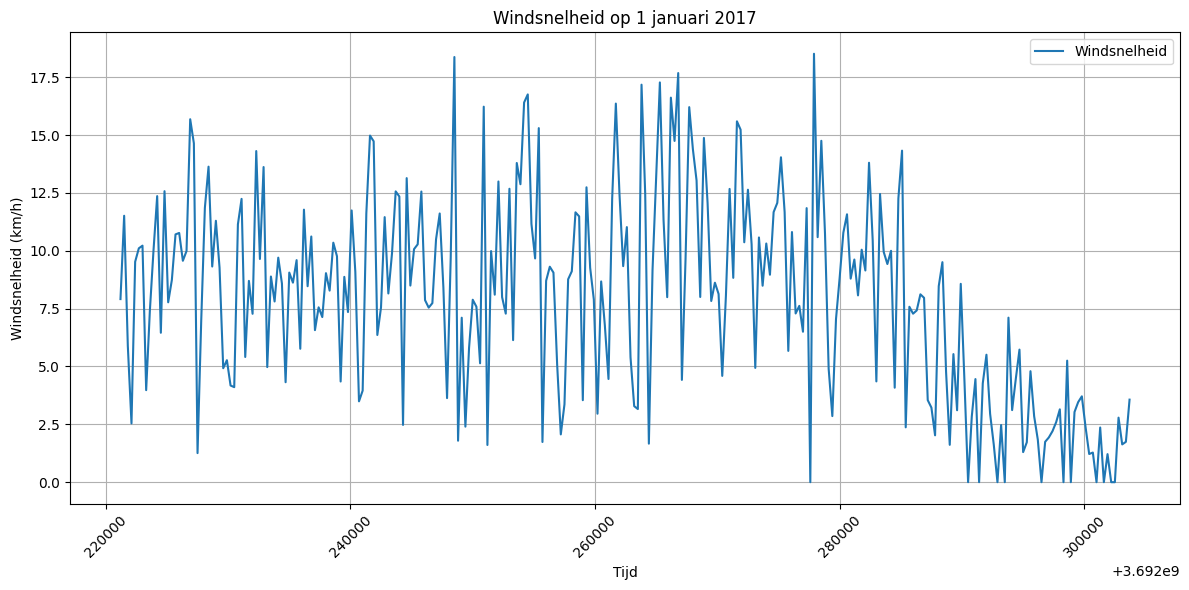

In [9]:
import matplotlib.pyplot as plt

# Filter de data voor 1 januari 2017
df_jan1_2017 = synced_df[
    (synced_df["Year"] == 2017) &
    (synced_df["Month"] == "January") &
    (synced_df["Day"] == 1)
]

# Controleer of de data niet leeg is
if df_jan1_2017.empty:
    print("Geen data beschikbaar voor 1 januari 2017.")
else:
    # Plot de windsnelheid
    plt.figure(figsize=(12, 6))
    plt.plot(
        df_jan1_2017["AbsTime[s]"], 
        df_jan1_2017["Act Wind Speed [km/h] (WeatherStation)"], 
        label="Windsnelheid"
    )
    plt.title("Windsnelheid op 1 januari 2017")
    plt.xlabel("Tijd")
    plt.ylabel("Windsnelheid (km/h)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # X-as labels draaien voor leesbaarheid
    plt.tight_layout()
    plt.show()


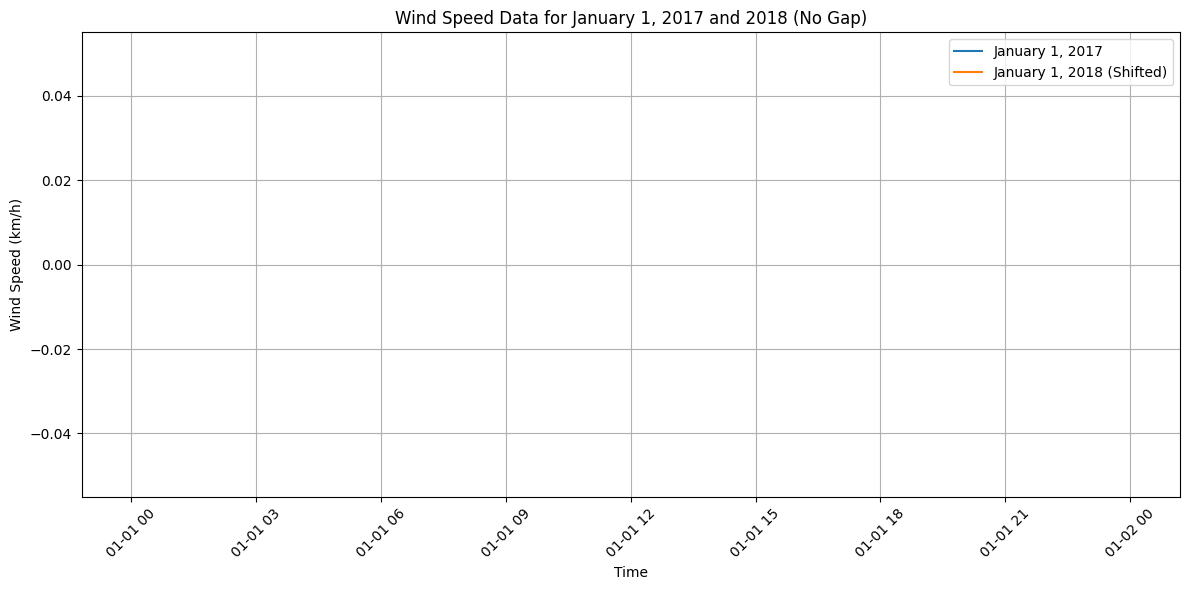

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Filter data for January 1, 2017 and January 1, 2018
df_jan1_2017 = synced_df[
    (synced_df["Year"] == 2017) & (synced_df["Month"] == 1) & (synced_df["Day"] == 1)
].copy()

df_jan1_2018 = synced_df[
    (synced_df["Year"] == 2018) & (synced_df["Month"] == 1) & (synced_df["Day"] == 1)
].copy()

# 2) Convert "Year", "Month", "Day", "Time" into a proper datetime column
df_jan1_2017["datetime"] = pd.to_datetime(
    df_jan1_2017["Year"].astype(str) + "-" +
    df_jan1_2017["Month"].astype(str) + "-" +
    df_jan1_2017["Day"].astype(str) + " " +
    df_jan1_2017["Time"].astype(str),
    errors="coerce"
)

df_jan1_2018["datetime"] = pd.to_datetime(
    df_jan1_2018["Year"].astype(str) + "-" +
    df_jan1_2018["Month"].astype(str) + "-" +
    df_jan1_2018["Day"].astype(str) + " " +
    df_jan1_2018["Time"].astype(str),
    errors="coerce"
)

# 3) Adjust 2018 dates to follow 2017 for a continuous plot
df_jan1_2018["datetime"] = df_jan1_2018["datetime"] + pd.DateOffset(days=1)

# 4) Plot wind speed data for both January 1st
plt.figure(figsize=(12, 6))

plt.plot(
    df_jan1_2017["datetime"],
    df_jan1_2017["Act Wind Speed [km/h] (WeatherStation)"],
    label="January 1, 2017"
)

plt.plot(
    df_jan1_2018["datetime"],
    df_jan1_2018["Act Wind Speed [km/h] (WeatherStation)"],
    label="January 1, 2018 (Shifted)"
)

plt.title("Wind Speed Data for January 1, 2017 and 2018 (No Gap)")
plt.xlabel("Time")
plt.ylabel("Wind Speed (km/h)")
plt.legend()
plt.grid(True)

# Optional: Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
